In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os, sys, scipy
import h5py
from astropy import units as u
import specutils, astropy, ccdproc
from tqdm import tqdm_notebook
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
from math import log10

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['font.size'] = 15

In [2]:
DATA_DIR = '/Users/arcticfox/Documents/atmospheres/v1298tau/'
REDUCED_DIR = '/Users/arcticfox/Documents/atmospheres/v1298tau/reduced/'
FILES = np.sort([os.path.join(DATA_DIR, i) for i in os.listdir(DATA_DIR) 
                          if i.endswith('.bz2')])

In [20]:
os.listdir(REDUCED_DIR)

['N20200122G0044m.fits.bz2',
 'N20200122G0042m.npy',
 'N20200122G0054m.npy',
 'sodium.png',
 'N20200122G0050m.fits.bz2',
 'md5sums.txt',
 'N20200122G0078m.npy',
 'N20200122G0071m.fits.bz2',
 'N20200122G0065m.fits.bz2',
 'N20200122G0039m.npy',
 'N20200122G0083i.fits.bz2',
 'N20200122G0081m.npy',
 'N20200122G0049m.fits.bz2',
 'N20200122G0080m.fits.bz2',
 'N20200122G0066i.fits.bz2',
 'N20200122G0072i.fits.bz2',
 'N20200122G0058m.npy',
 'N20200122G0074m.npy',
 'N20200122G0053i.fits.bz2',
 'N20200122G0068m.fits.bz2',
 'N20200122G0062m.npy',
 'N20200122G0047i.fits.bz2',
 'N20200122G0077m.fits.bz2',
 'N20200122G0063m.npy',
 'N20200122G0058i.fits.bz2',
 'N20200122G0085i.fits.bz2',
 'N20200122G0075m.npy',
 'N20200122G0063m.fits.bz2',
 'N20200122G0038m.fits.bz2',
 'N20200122G0042m.fits.bz2',
 'N20200122G0059m.npy',
 'N20200122G0056m.fits.bz2',
 'N20200122G0079i.fits.bz2',
 'N20200122G0080m.npy',
 'N20200122G0038m.npy',
 'N20200122G0055i.fits.bz2',
 'N20200122G0041i.fits.bz2',
 'N20200122G0088i.f

In [3]:
fb = h5py.File(os.path.join(DATA_DIR, 'telluric_model_b.hdf'), 'r')
fr = h5py.File(os.path.join(DATA_DIR, 'telluric_model_r.hdf'), 'r')

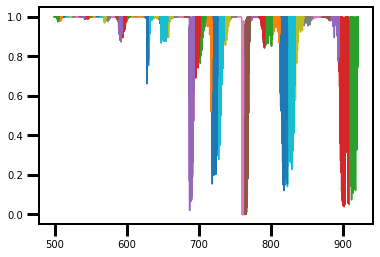

In [4]:
for keys in list(fb['wavelength_solution']['fiber_2'].keys()):
    plt.plot(np.array(fb['wavelength_solution']['fiber_2'][keys]),
             np.array(fb['telluric_model']['fiber_2'][keys]))
for keys in list(fr['wavelength_solution']['fiber_2'].keys()):
    plt.plot(np.array(fr['wavelength_solution']['fiber_2'][keys]),
             np.array(fr['telluric_model']['fiber_2'][keys]))

In [5]:
def resave(files):
    global DATA_DIR
    times = np.array([])
    for fn in tqdm_notebook(files):
        name = fn.split('.')[0]
        hdu = fits.open(fn)
        dattype = hdu[0].header['OBSTYPE']

        if hdu[0].header['EREADSPD'] == 'Normal: 4.15e noise, 1.30e/ADU, 19s':
            np.save('{0}_{1}.npy'.format(name, dattype), hdu[0].data)
            if dattype == 'OBJECT':
                times = np.append(times, hdu[0].header['MJDATE'])
                #plt.imshow(hdu[0].data.T, origin='lower', 
                #           vmin=np.nanpercentile(hdu[0].data.T, 15),
                #           vmax=np.nanpercentile(hdu[0].data.T, 85))
                #plt.title(hdu[0].header['MJDATE'])
                #plt.show()
    np.save(os.path.join(DATA_DIR, 'mjddates.npy'), times)

In [6]:
resave(FILES)

In [8]:
FILES = os.listdir(DATA_DIR)
SCIENCE_FRAMES = np.sort([os.path.join(DATA_DIR, i) for i in FILES if i.endswith('_OBJECT.npy')])
BIAS_FRAMES = np.sort([os.path.join(DATA_DIR, i) for i in FILES if i.endswith('_BIAS.npy')])
FLAT_FRAMES = np.sort([os.path.join(DATA_DIR, i) for i in FILES if i.endswith('_FLAT.npy')])
ARC_FRAMES  = np.sort([os.path.join(DATA_DIR, i) for i in FILES if i.endswith('_ARC.npy')])
TIMES = np.load(os.path.join(DATA_DIR,'mjddates.npy'), allow_pickle=True)

## Creating the Master Dark

In [17]:
def master_file(files, output_fn):
    global DATA_DIR
    arrs = []
    for fn in tqdm_notebook(files):
        d = np.load(fn, allow_pickle=True)
        arrs.append(d)
    arrs = np.array(arrs)
    meddark = np.nanmedian(arrs, axis=0)
    np.save(os.path.join(DATA_DIR, output_fn), meddark)
    return meddark

#MEDDARK = master_file(BIAS_FRAMES, 'master_dark.npy')
MEDDARK = np.load(os.path.join(DATA_DIR, 'master_dark.npy'), allow_pickle=True)

TypeError: Invalid shape () for image data

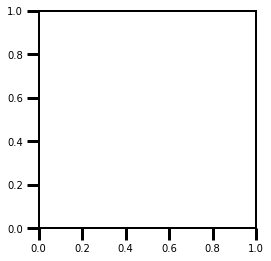

In [18]:
plt.imshow(MEDDARK.T, origin='lower')
plt.colorbar()
plt.show();

## Subtracting master dark from every file

In [12]:
len(SCIENCE_FRAMES)

0

In [12]:
def subtract_dark(files):
    global MEDDARK
    
    for fn in tqdm_notebook(files):
        d = np.load(fn, allow_pickle=True)
       # plt.imshow(d.T, origin='lower', vmin=np.nanpercentile(d,15),
       #          vmax=np.nanpercentile(d,85))
       # plt.show()
        name = fn[:-4] + '_biasSub.npy'
        np.save(name, d - MEDDARK)
        
subtract_dark(SCIENCE_FRAMES)
#subtract_dark(FLAT_FRAMES)
#subtract_dark(ARC_FRAMES)

## Creating Master Flat

In [13]:
MEDFLAT = master_file(FLAT_FRAMES, 'master_flat.npy')
#MEDFLAT = np.load(os.path.join(DATA_DIR, 'master_flat.npy'), allow_pickle=True)

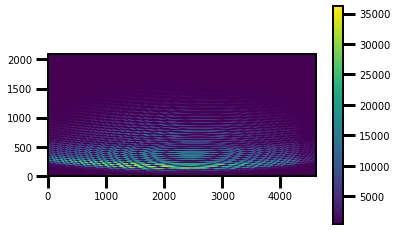

In [14]:
plt.imshow(MEDFLAT.T, origin='lower')
plt.colorbar()
plt.show()

## Divide out Master Flat

In [15]:
# column median order by order and smooth and divide out of flat field row by row
# gets pixel-to-pixel sensitivity variations and divide that out

def flat_removal(files):
    global MEDFLAT
    for fn in tqdm_notebook(files):
        d = np.load(fn[:-4]+'_biasSub.npy', allow_pickle=True)
        name = fn[:-4] + '_biasSub_flatSub.npy'
        np.save(name, d/MEDFLAT)

flat_removal(SCIENCE_FRAMES)

## Extracting the orders

In [16]:
for i, fn in enumerate(SCIENCE_FRAMES):
    name = fn[:-4] + '_biasSub_flatSub.npy'
    if i == 0:
        SUMMEDFRAME = np.load(name, allow_pickle=True)
    else:
        SUMMEDFRAME += np.load(name, allow_pickle=True)

In [18]:
def group_inds(values):
    results = []

    for i, v in enumerate(values):
        if i == 0:
            mini = maxi = v
            temp = [v]
        else:
            # SETS 10 CADENCE LIMIT                                                                                                                    
            if (np.abs(v-maxi) < 7):
                temp.append(v)
                if v > maxi:
                    maxi = v
                if v < mini:
                    mini = v
            else:
                results.append(temp)
                mini = maxi = v
                temp = [v]

            # GETS THE LAST GROUP                                                                                                                     
            if i == len(values)-1:
                results.append(temp)

    return np.array(results)

In [19]:
def find_gap_middle(midcol_dat):
    x = np.arange(len(midcol_dat))
    
    plt.figure(figsize=(14,4))

    plt.plot(x, midcol_dat, 'w')

    filt = scipy.ndimage.filters.minimum_filter1d(midcol_dat,
                                             size=30)

    fit = np.polyfit(x, filt, deg=8)
    model = np.poly1d(fit)
    midcol_fit = model(x)

    dists = np.sqrt((midcol_fit-midcol_dat)**2)
    minima = np.where((dists <= np.nanmin(dists) + 0.3*np.nanstd(dists)))[0]

    plt.plot(x[minima], midcol_fit[minima], 'b.')
#    plt.plot(x, midcol_fit, 'k')

    medminima = group_inds(minima)

    starting_x, starting_y = [], []
    
    for m in medminima:
        ind = np.nanmedian(m)
#        print(ind)
#        if ind % 1 == 0:
#            starting_x.append(x[int(ind)])
#            starting_y.append(midcol_dat[int(ind)])
#       else:
        floor, ceil = int(np.floor(ind)), int(np.ceil(ind))
        starting_x.append(np.nanmean([x[floor], x[ceil]]))
        starting_y.append(np.nanmean([midcol_dat[floor],
                                          midcol_dat[ceil]]))


    starting_x = np.array(starting_x[1:-1])
    starting_y = np.array(starting_y[1:-1])

    plt.plot(starting_x, starting_y, 'ro')
    plt.ylim(-1,40)
    # Ben doubted himself with the argmin 02/03/2020
    plt.show()
    
    return starting_x, starting_y

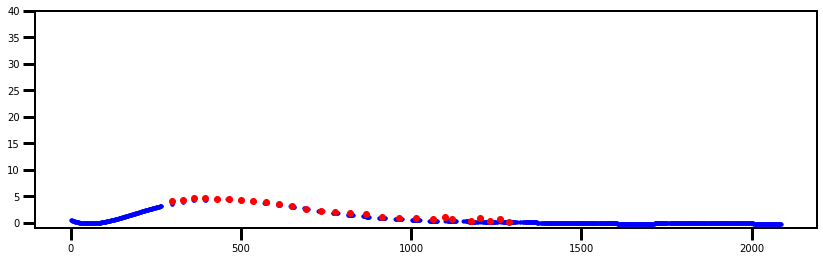

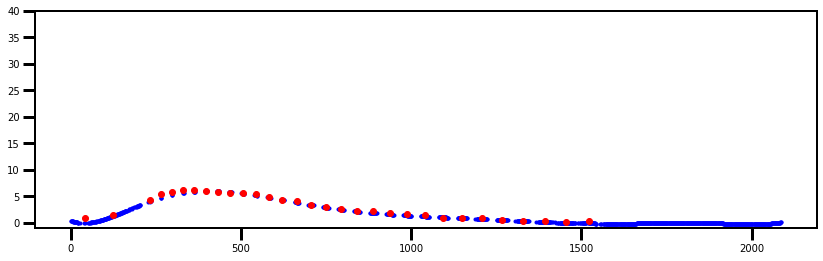

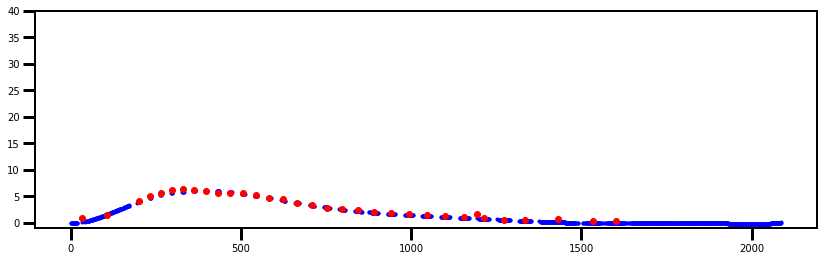

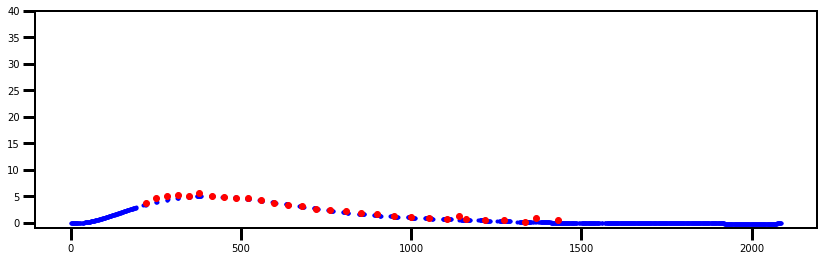

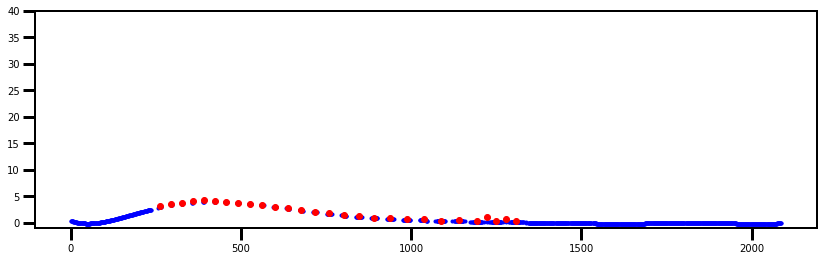

In [20]:
%matplotlib inline

midcol = int(SUMMEDFRAME.shape[0]/2)

midcol_dat = SUMMEDFRAME[midcol:midcol+1][0]
tip_x, tip_y = find_gap_middle(SUMMEDFRAME[500:501][0])
start_x, start_y = find_gap_middle(SUMMEDFRAME[midcol-1000:midcol-999][0])

middle_x, middle_y = find_gap_middle(midcol_dat)
end_x, end_y = find_gap_middle(SUMMEDFRAME[midcol+1000:midcol+10001][0])
butt_x, butt_y = find_gap_middle(SUMMEDFRAME[4000:4001][0])

In [21]:
diff = np.diff([136, 172, 201])
cumsum = np.cumsum(diff)

tip_start, start_start = 197, 136
mid_start, end_start   = 101, 123
butt_start = 171
tip_x = np.sort(np.append(tip_x, np.append([tip_start], tip_start+cumsum)))
start_x = np.sort(np.append(start_x, np.append([start_start], start_start+cumsum)))
middle_x = np.sort(np.append(middle_x, np.append([mid_start], mid_start+cumsum)))
end_x = np.sort(np.append(end_x, np.append([end_start], end_start+cumsum)))
butt_x = np.sort(np.append(butt_x, np.append([butt_start], butt_start+cumsum)))

In [22]:
len(tip_x)-np.array([2,4,7])

array([28, 26, 23])

<IPython.core.display.Javascript object>


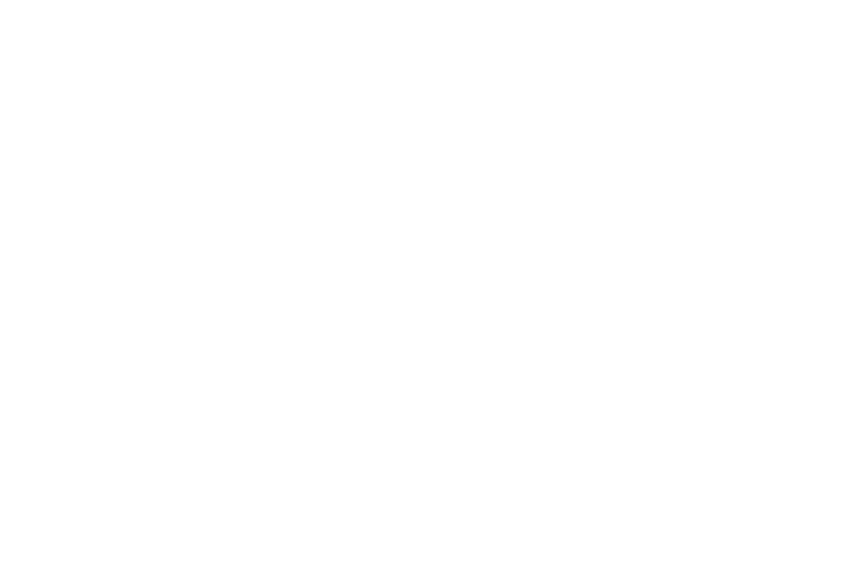

<IPython.core.display.Javascript object>


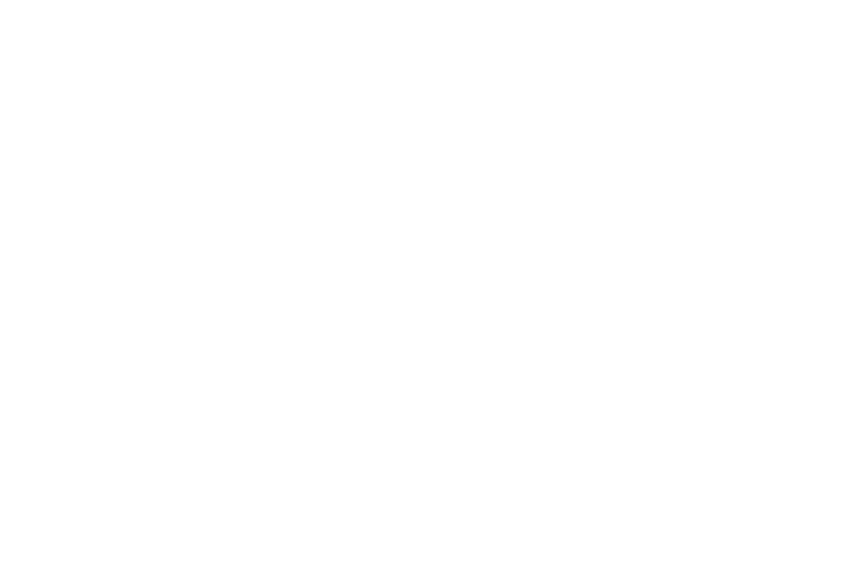

In [23]:
%matplotlib inline
%matplotlib notebook
%matplotlib notebook

plt.imshow(SUMMEDFRAME.T, vmin=0, vmax=15)

all_points_x = np.array([tip_x[np.delete(np.arange(0,len(tip_x),1,dtype=int),
                                         len(tip_x)-np.array([2,4,7],dtype=int))],
                         start_x[2:-5],
                         middle_x[2:-7],
                         end_x[:-5][np.delete(np.arange(0,len(end_x[:-5]),1,dtype=int),
                                              len(end_x[:-5])-2)],
                         butt_x[:-4]])


all_points_y = np.array([500,
                         int(SUMMEDFRAME.shape[0]/2-1000),
                         int(SUMMEDFRAME.shape[0]/2),
                         int(SUMMEDFRAME.shape[0]/2+1000),
                         4000])

fit_x = np.arange(0,SUMMEDFRAME.shape[0],1)

#models = np.zeros((all_points_x.shape[1], len(fit_x)))

for i in range(len(all_points_x)):
    plt.plot(np.full(len(all_points_x[i]), all_points_y[i]), all_points_x[i], '.')

#plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


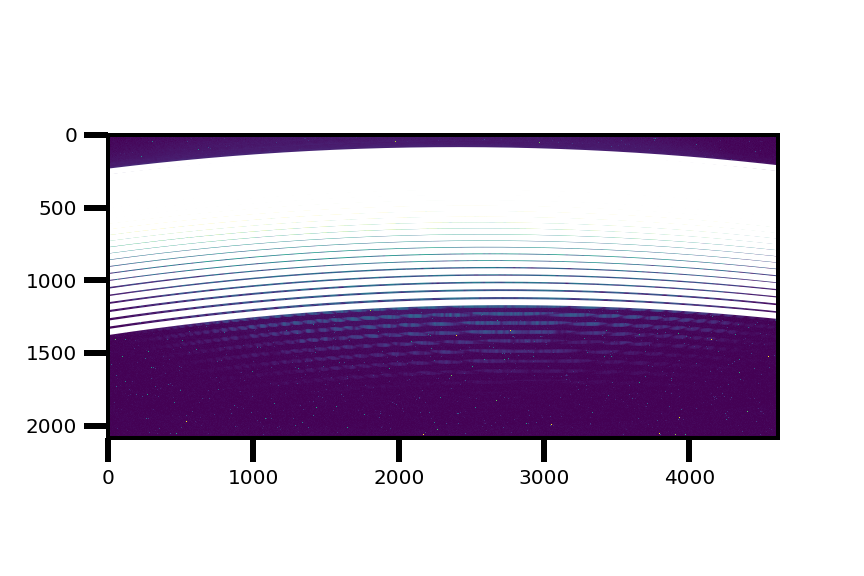

In [24]:
%matplotlib inline
%matplotlib notebook
%matplotlib notebook

MODELS = np.zeros((all_points_x.shape[1], len(fit_x)))
plt.imshow(SUMMEDFRAME.T, vmin=0, vmax=15)
for i in range(all_points_x.shape[1]):
    fit = np.polyfit(all_points_y, all_points_x[:,i], deg=2)
    model = np.poly1d(fit)
    MODELS[i] = model(fit_x)
    plt.plot(fit_x, model(fit_x), 'w', lw=3)


## Discretize model gap fits

In [25]:
DISCRETE = np.zeros(MODELS.shape, dtype=int)
for i in range(len(MODELS)):
    DISCRETE[i] = np.round(MODELS[i])

In [26]:
DISCRETE.shape

(27, 4608)

## Summing the orders

In [27]:
FLUXES = np.zeros((DISCRETE.shape[0]-1, len(DISCRETE[0])))

for i in range(0, DISCRETE.shape[0]-1):
    top = DISCRETE[i] + 0
    bottom = DISCRETE[i+1] + 0
    for j in range(top.shape[0]):
        FLUXES[i][j] = np.nansum(SUMMEDFRAME[j, top[j]:bottom[j]])

## Gettin Barycentric Correction

In [28]:
def get_barycorr(files):
    global TIMES
    corr = np.zeros(len(TIMES))
    for i in tqdm_notebook(range(len(TIMES))):
        keck = EarthLocation.from_geodetic(lat=19.8283*u.deg, 
                                   lon=-155.4783*u.deg, height=4160*u.m)
        sc = SkyCoord('04:05:19.6', '+20:09:25.6', unit=(u.hourangle, u.deg))
        barycorr = sc.radial_velocity_correction('heliocentric',
                                                 obstime=Time(TIMES[i], format='mjd'), 
                                                 location=keck)
        bc = barycorr.to(u.km/u.s) 
        corr[i] = bc.value
    return corr

In [29]:
BARYCORR = get_barycorr(SCIENCE_FRAMES) * u.km / u.s

## Get Wavelength & Orders from a File

In [30]:
hdu = fits.open('/Users/arcticfox/Documents/atmospheres/v1298tau/reduced/N20200122G0066m.fits.bz2')
WAVELENGTH = hdu[0].data[4] * u.nm
ORDERS = hdu[0].data[0]
hdu.close()

## Matching Wavelengths

In [31]:
ORDER_START = 23
CUT_END = 350

In [32]:
def extract_data(file, barycorr):
    global REDUCED_DIR, WAVELENGTH, ORDERS, ORDER_START, CUT_END, DISCRETE
    
    # LOAD IN DATA
    name = file[:-4] + '_biasSub_flatSub.npy'
    data = np.load(name, allow_pickle=True)
   # plt.imshow(data.T, origin='lower', vmin=np.nanpercentile(data,15),
   #           vmax=np.nanpercentile(data,85))
   # plt.colorbar()
   # plt.show()
    
    # BARYCENTRIC CORRECTION
    speedlight = 2.998e8 * u.m / u.s
    dopshift = ((WAVELENGTH * barycorr) / speedlight).to(u.nm)
    wavelength = (WAVELENGTH - dopshift).to(u.nm).value
    
    # SUM FLUXES BETWEEN ORDERS
    fluxes = np.zeros((DISCRETE.shape[0]-1, len(DISCRETE[0])))
    
    for i in range(0, DISCRETE.shape[0]-1):
        top = DISCRETE[i] + 0
        bottom = DISCRETE[i+1] + 0
        for j in range(top.shape[0]):
            fluxes[i][j] = np.nansum(data[j, top[j]:bottom[j]])
        
    # REMOVES THE BLAZE FUNCTION
    blaze_corr = np.zeros((DISCRETE.shape[0]-1, len(fluxes[0])-CUT_END))
    wave_corr  = np.zeros((DISCRETE.shape[0]-1, len(fluxes[0])-CUT_END))
    
    for i, o in enumerate(range(ORDER_START, ORDER_START+len(DISCRETE)-1)):
        # TAKE WAVELENGTHS IN A GIVEN ORDER AND INTERPOLATE ACROSS
        wave = wavelength[ORDERS==o]
        
        newwaves = np.logspace(log10(wave[0]), 
                               log10(wave[-1]), len(fluxes[i]), base=10.0)
        
        # FIT AND REMOVE BLAZE FUNCTION
        filt = scipy.ndimage.filters.percentile_filter(fluxes[i][:-CUT_END],
                                                       percentile=95, size=150)

        fit = np.polyfit(newwaves[:-CUT_END], filt, deg=8)
        model = np.poly1d(fit)
        bc = fluxes[i][:-CUT_END] / model(newwaves[:-CUT_END])

        blaze_corr[i] = bc#[:-CUT_END]
        wave_corr[i]  = newwaves[:-CUT_END]
    return wave_corr, blaze_corr

In [33]:
FLUXES.shape

(26, 4608)

In [34]:
%matplotlib inline

WAVELENGTHS = np.zeros((len(SCIENCE_FRAMES), FLUXES.shape[0], FLUXES.shape[1]-CUT_END))
SPECTRA = np.zeros((len(SCIENCE_FRAMES), FLUXES.shape[0], FLUXES.shape[1]-CUT_END))

for i in range(len(SCIENCE_FRAMES)):
    wc, bc = extract_data(SCIENCE_FRAMES[i], BARYCORR[i])
    WAVELENGTHS[i] = wc
    SPECTRA[i] = bc

In [35]:
SPECTRA.shape

(56, 26, 4258)

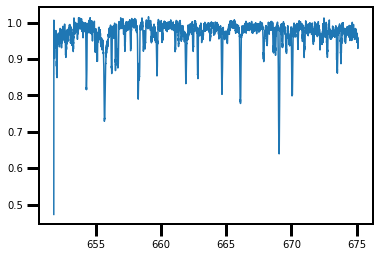

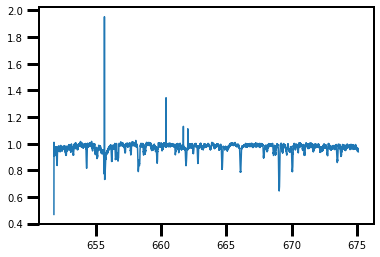

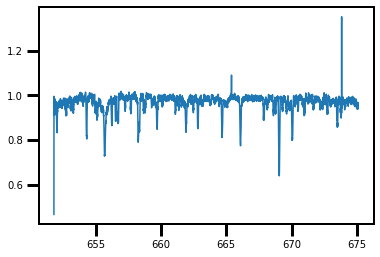

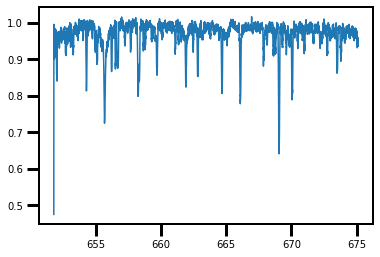

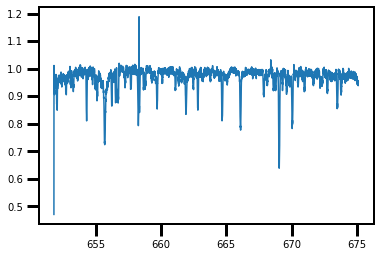

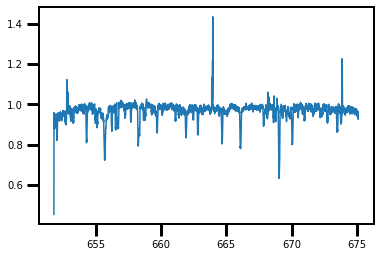

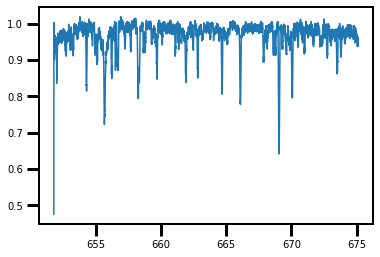

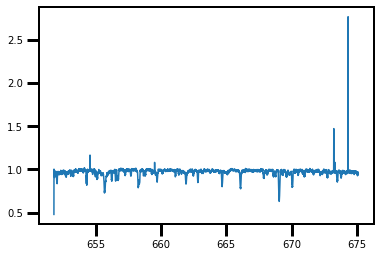

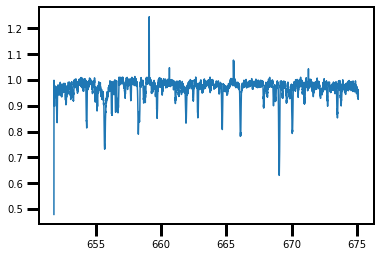

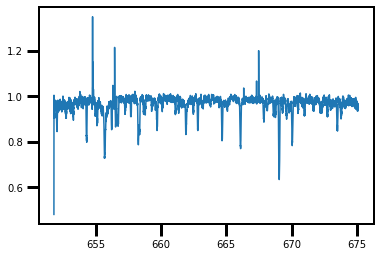

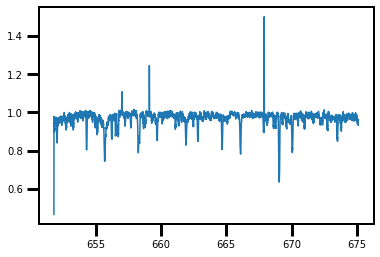

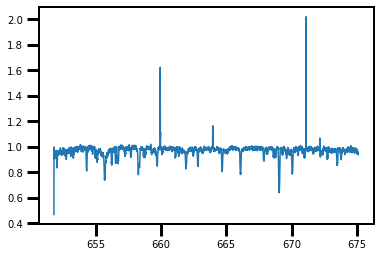

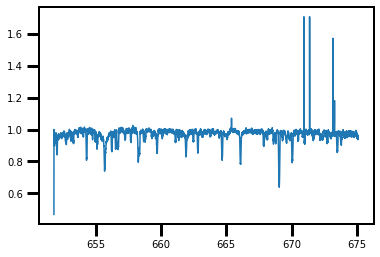

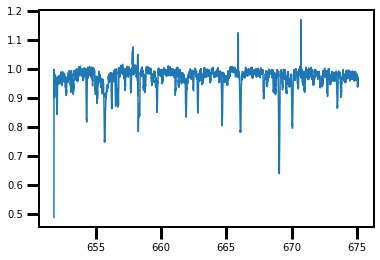

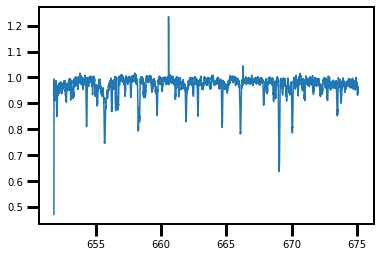

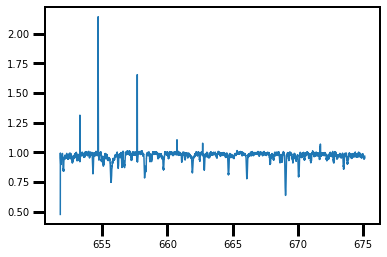

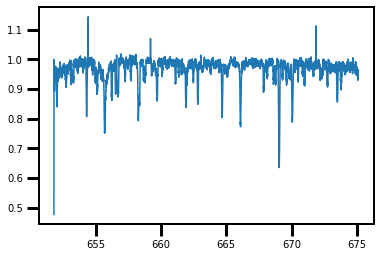

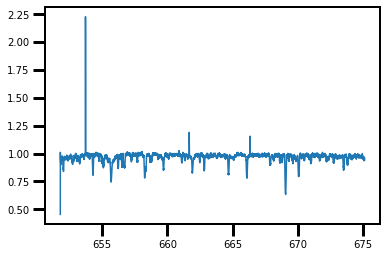

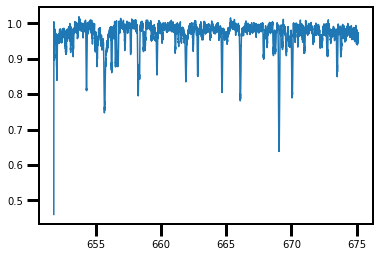

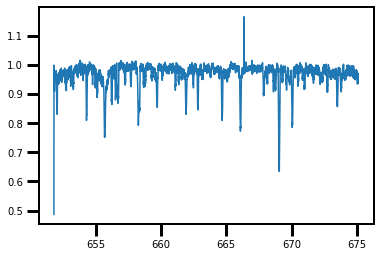

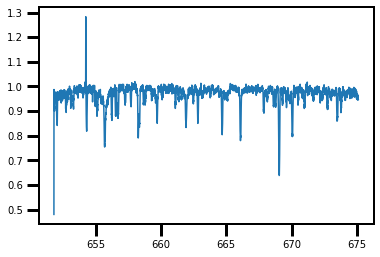

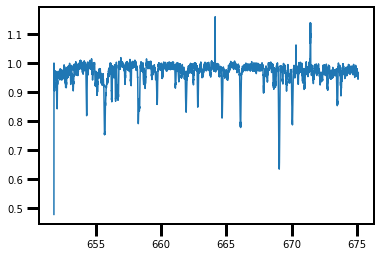

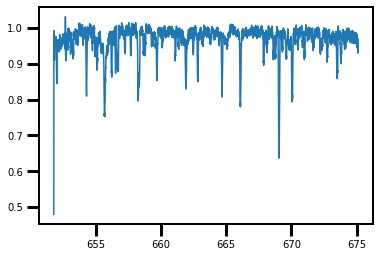

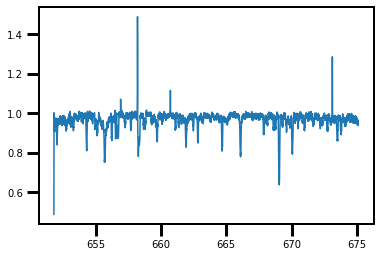

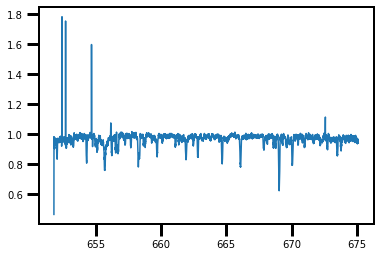

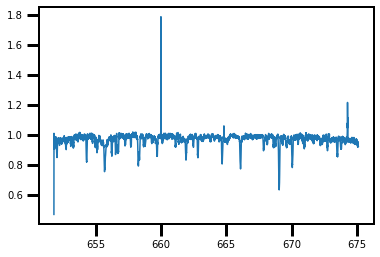

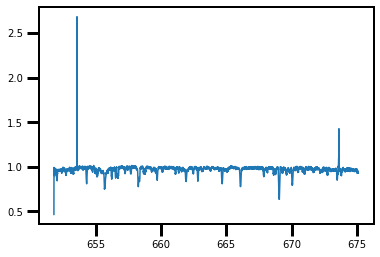

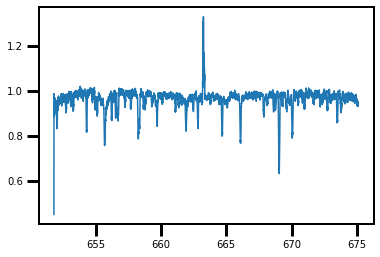

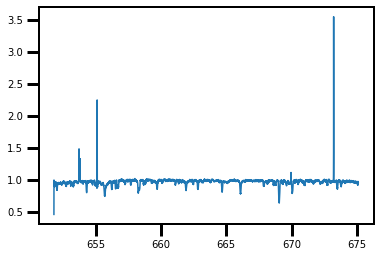

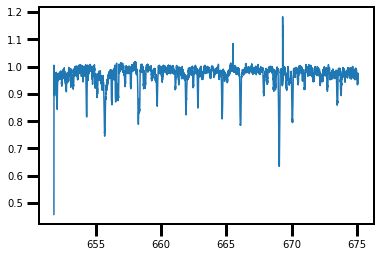

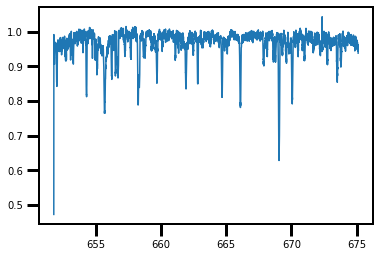

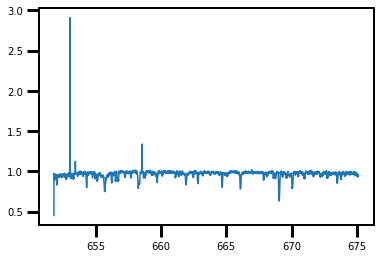

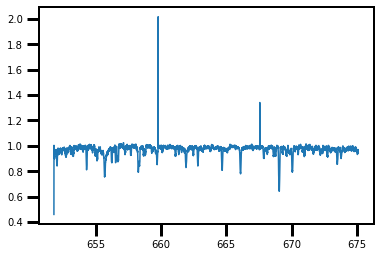

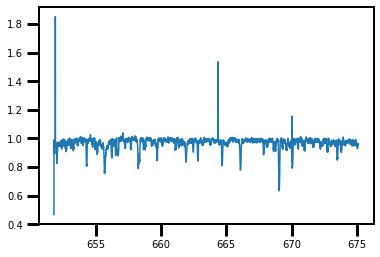

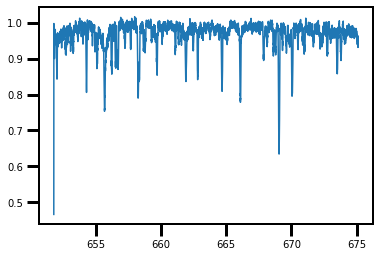

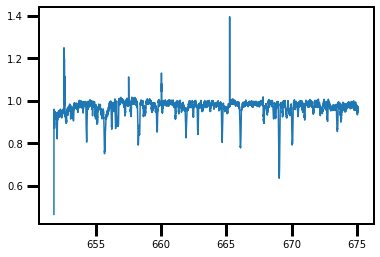

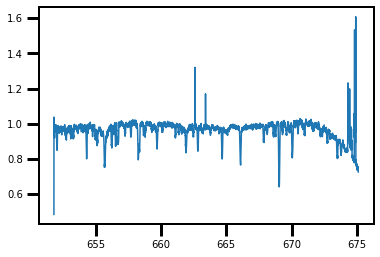

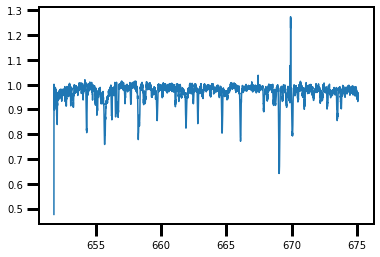

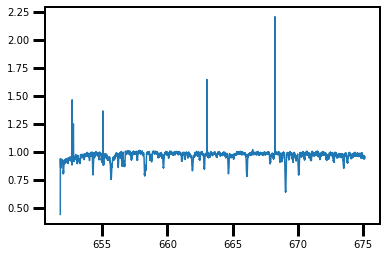

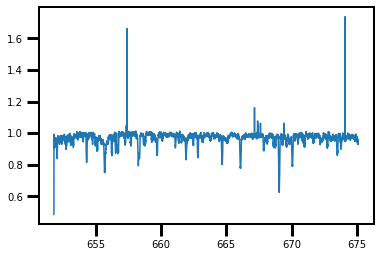

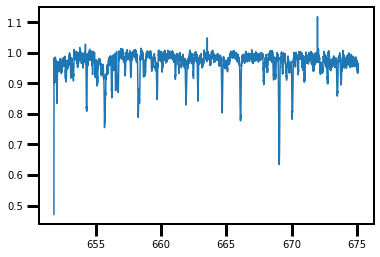

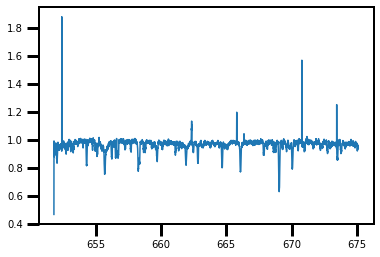

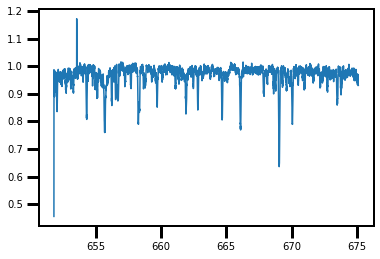

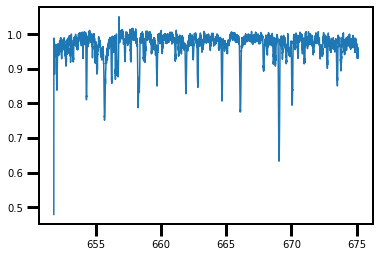

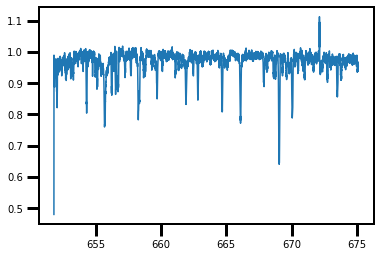

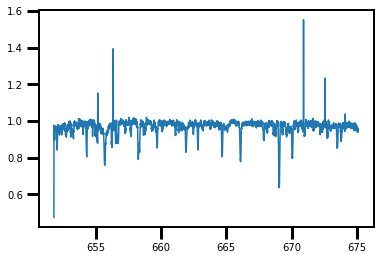

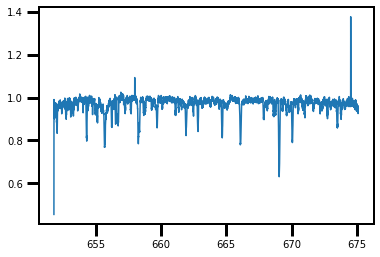

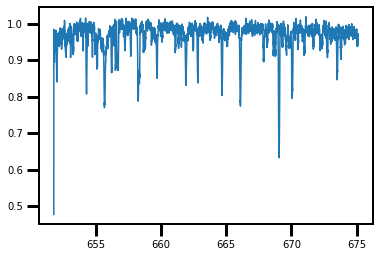

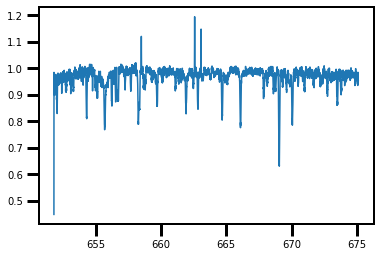

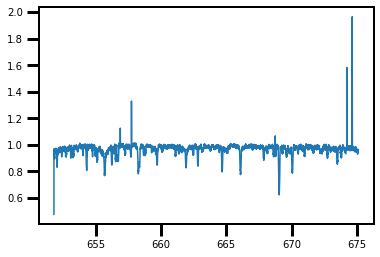

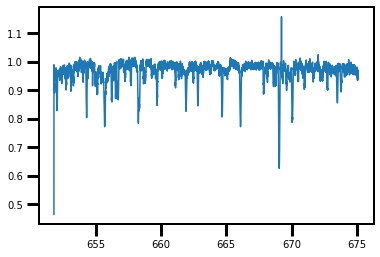

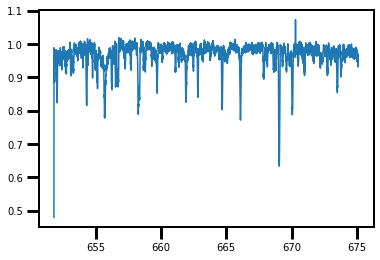

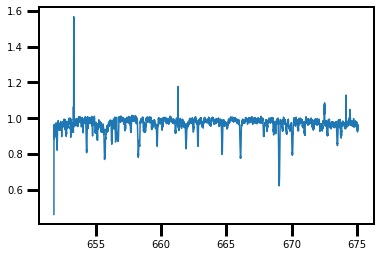

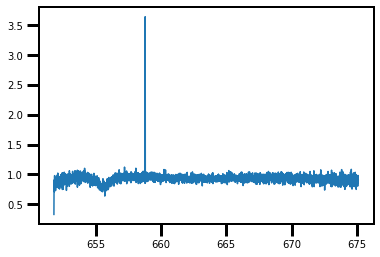

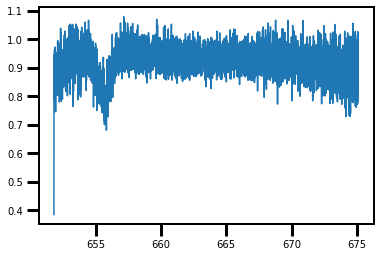

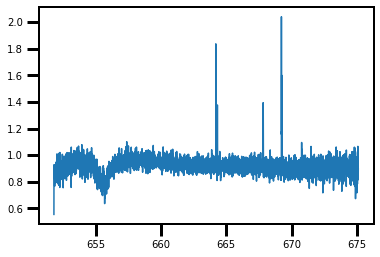

In [36]:
for i in range(len(WAVELENGTHS)):
    plt.plot(WAVELENGTHS[i][11], SPECTRA[i][11])
    plt.show()

In [62]:
SPECTRA.shape

(56, 26, 4258)

In [66]:
reshapef = np.reshape(SPECTRA[11], SPECTRA[11].shape[0]*SPECTRA[11].shape[1])
reshapew = np.reshape(WAVELENGTHS[11], WAVELENGTHS[11].shape[0]*WAVELENGTHS[11].shape[1])
j = 0
for i in range(WAVELENGTHS[11].shape[0]*WAVELENGTHS[11].shape[1]):
    if i % SPECTRA.shape[2] == 0:
        order = ORDER_START + j
        j += 1
    with open(SCIENCE_FRAMES[11][:-4]+'.txt', 'a') as tf:
        tf.write('{}, {}, {}\n'.format(order, reshapew[i], reshapef[i]))

## Interpolating the Wavelengths

In [33]:
def grid_wavelength(wavelength, spectra, factor):
    
    interp_waves = np.zeros((wavelength.shape[0], wavelength.shape[1]*factor))
    interp_spect = np.zeros((spectra.shape[0], spectra.shape[1]*factor))
    
    start = wavelength[:,0]
    end = wavelength[:,-1]

    redstart = np.nanmax(start)
    blueend  = np.nanmin(end)

    finer_wavelength = np.logspace(log10(redstart), log10(blueend),
                                   wavelength.shape[1]*factor, base=10.0)
    for i in range(len(wavelength)):
        f = interp1d(wavelength[i], spectra[i])
        interp_spect[i] = f(finer_wavelength)
        interp_waves[i] = finer_wavelength
    return interp_waves, interp_spect

In [34]:
FACTOR = 3

INTERPOLATED_WAVELENGTH = np.zeros( (WAVELENGTHS.shape[0], WAVELENGTHS.shape[1], 
                                     WAVELENGTHS.shape[2]*FACTOR)  )
INTERPOLATED_SPECTRA = np.zeros( (WAVELENGTHS.shape[0], WAVELENGTHS.shape[1], 
                                     WAVELENGTHS.shape[2]*FACTOR)  )

for i, order in enumerate(range(WAVELENGTHS.shape[1])):
    iw, iss = grid_wavelength(WAVELENGTHS[:,order], SPECTRA[:,order], FACTOR)
    INTERPOLATED_WAVELENGTH[:,i] = iw
    INTERPOLATED_SPECTRA[:,i] = iss

In [35]:
INTERPOLATED_SPECTRA.shape

(56, 26, 12774)

## Accounting for stellar RV

In [36]:
star_bc = 16.15 * u.km / u.s
speedlight = 2.998e8 * u.m / u.s
dopshift = ((INTERPOLATED_WAVELENGTH*u.nm * star_bc) / speedlight).to(u.nm)
INTERPOLATED_WAVELENGTH = (INTERPOLATED_WAVELENGTH*u.nm - dopshift).to(u.nm).value

## Saving interpolated data

In [37]:
INTERPOLATED_SPECTRA.shape, INTERPOLATED_WAVELENGTH.shape

((56, 26, 12774), (56, 26, 12774))

In [38]:
np.save('interp_1d_wavelength.npy', INTERPOLATED_WAVELENGTH)
np.save('interp_1d_spectra.npy', INTERPOLATED_SPECTRA)

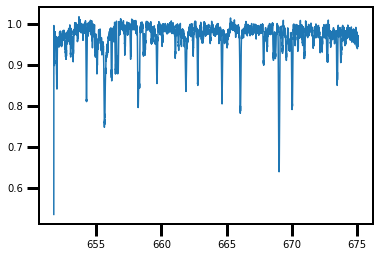

In [138]:
plt.plot(INTERPOLATED_WAVELENGTH[18][11],INTERPOLATED_SPECTRA[18][11])